In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.lib.recfunctions import drop_fields, repack_fields
from mpl_toolkits.mplot3d import Axes3D

# Read Dataset

In [2]:
filepath = 'watch_test2_sample.csv'

rec_raw = np.genfromtxt(filepath, 
                delimiter=',',
                names=True,
                dtype=None,
#                 skip_header=1,
#                 usecols=np.arange(13),
#                 converters={0: lambda x: np.datetime64(x)},
                )

rec_dtype = [
                ('uts', '<M8[s]'),
                ('accelerateX', '<f8'),
                ('accelerateY', '<f8'),
                ('accelerateZ', '<f8'),
                ('compass', '<f8'),
                ('gpsx', '<f8'),
                ('gpsy', '<f8'),
                ('gyrox', '<f8'),
                ('gyroy', '<f8'),
                ('gyroz', '<f8'),
                ('heartrate', '<f8'),
                ('light', '<f8'),
                ('pressure', '<f8')
            ]

rec_raw = rec_raw.astype(rec_dtype)

rec_raw.shape, rec_raw.dtype

/home/j/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  
/home/j/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


((6276,),
 dtype([('uts', '<M8[s]'), ('accelerateX', '<f8'), ('accelerateY', '<f8'), ('accelerateZ', '<f8'), ('compass', '<f8'), ('gpsx', '<f8'), ('gpsy', '<f8'), ('gyrox', '<f8'), ('gyroy', '<f8'), ('gyroz', '<f8'), ('heartrate', '<f8'), ('light', '<f8'), ('pressure', '<f8')]))

# Drop Duplicates or sort by time

In [3]:
u, rec_uni_index = np.unique(rec_raw['uts'], axis=0, return_index=True)
rec_uni = rec_raw[rec_uni_index]
rec_uni = np.sort(rec_uni, order='uts')

rec = drop_fields(rec_uni, 'uts')

rec_raw.shape, rec_uni.shape

((6276,), (263,))

# Plot Hist

/home/j/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/j/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


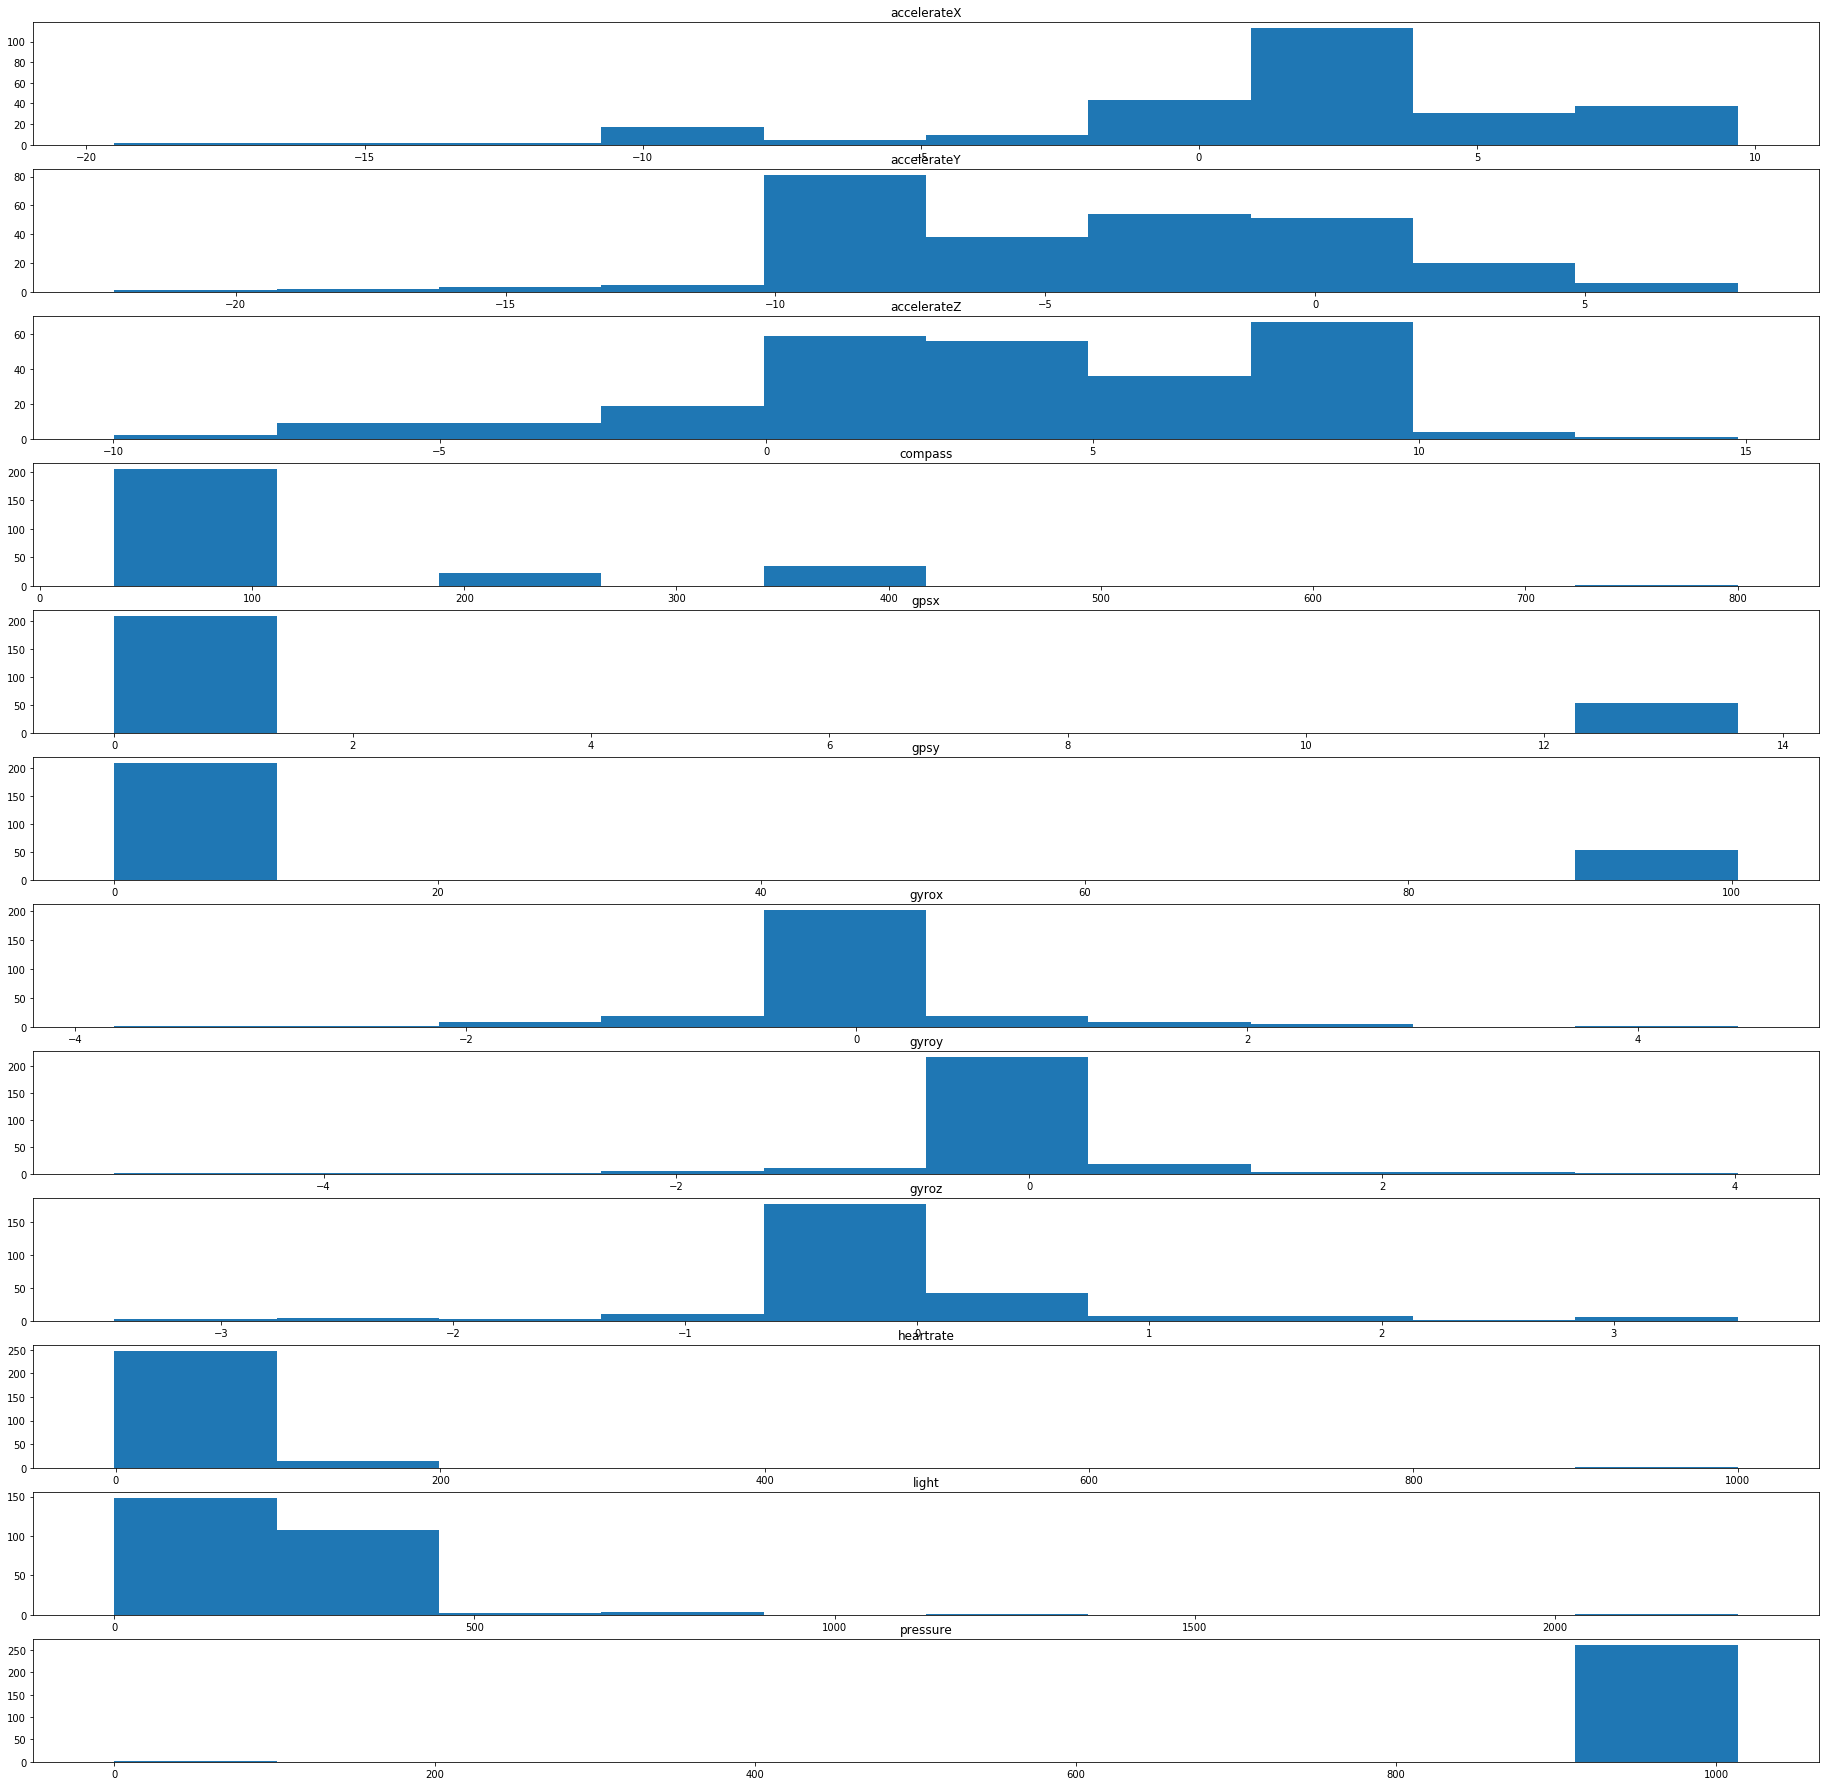

In [4]:
fig, ax = plt.subplots(len(rec.dtype), 1, figsize = (32, 32))
for i, col in enumerate(rec.dtype.names):
    ax[i].hist(rec[col])
    ax[i].set_title(col)

# Plot Scater

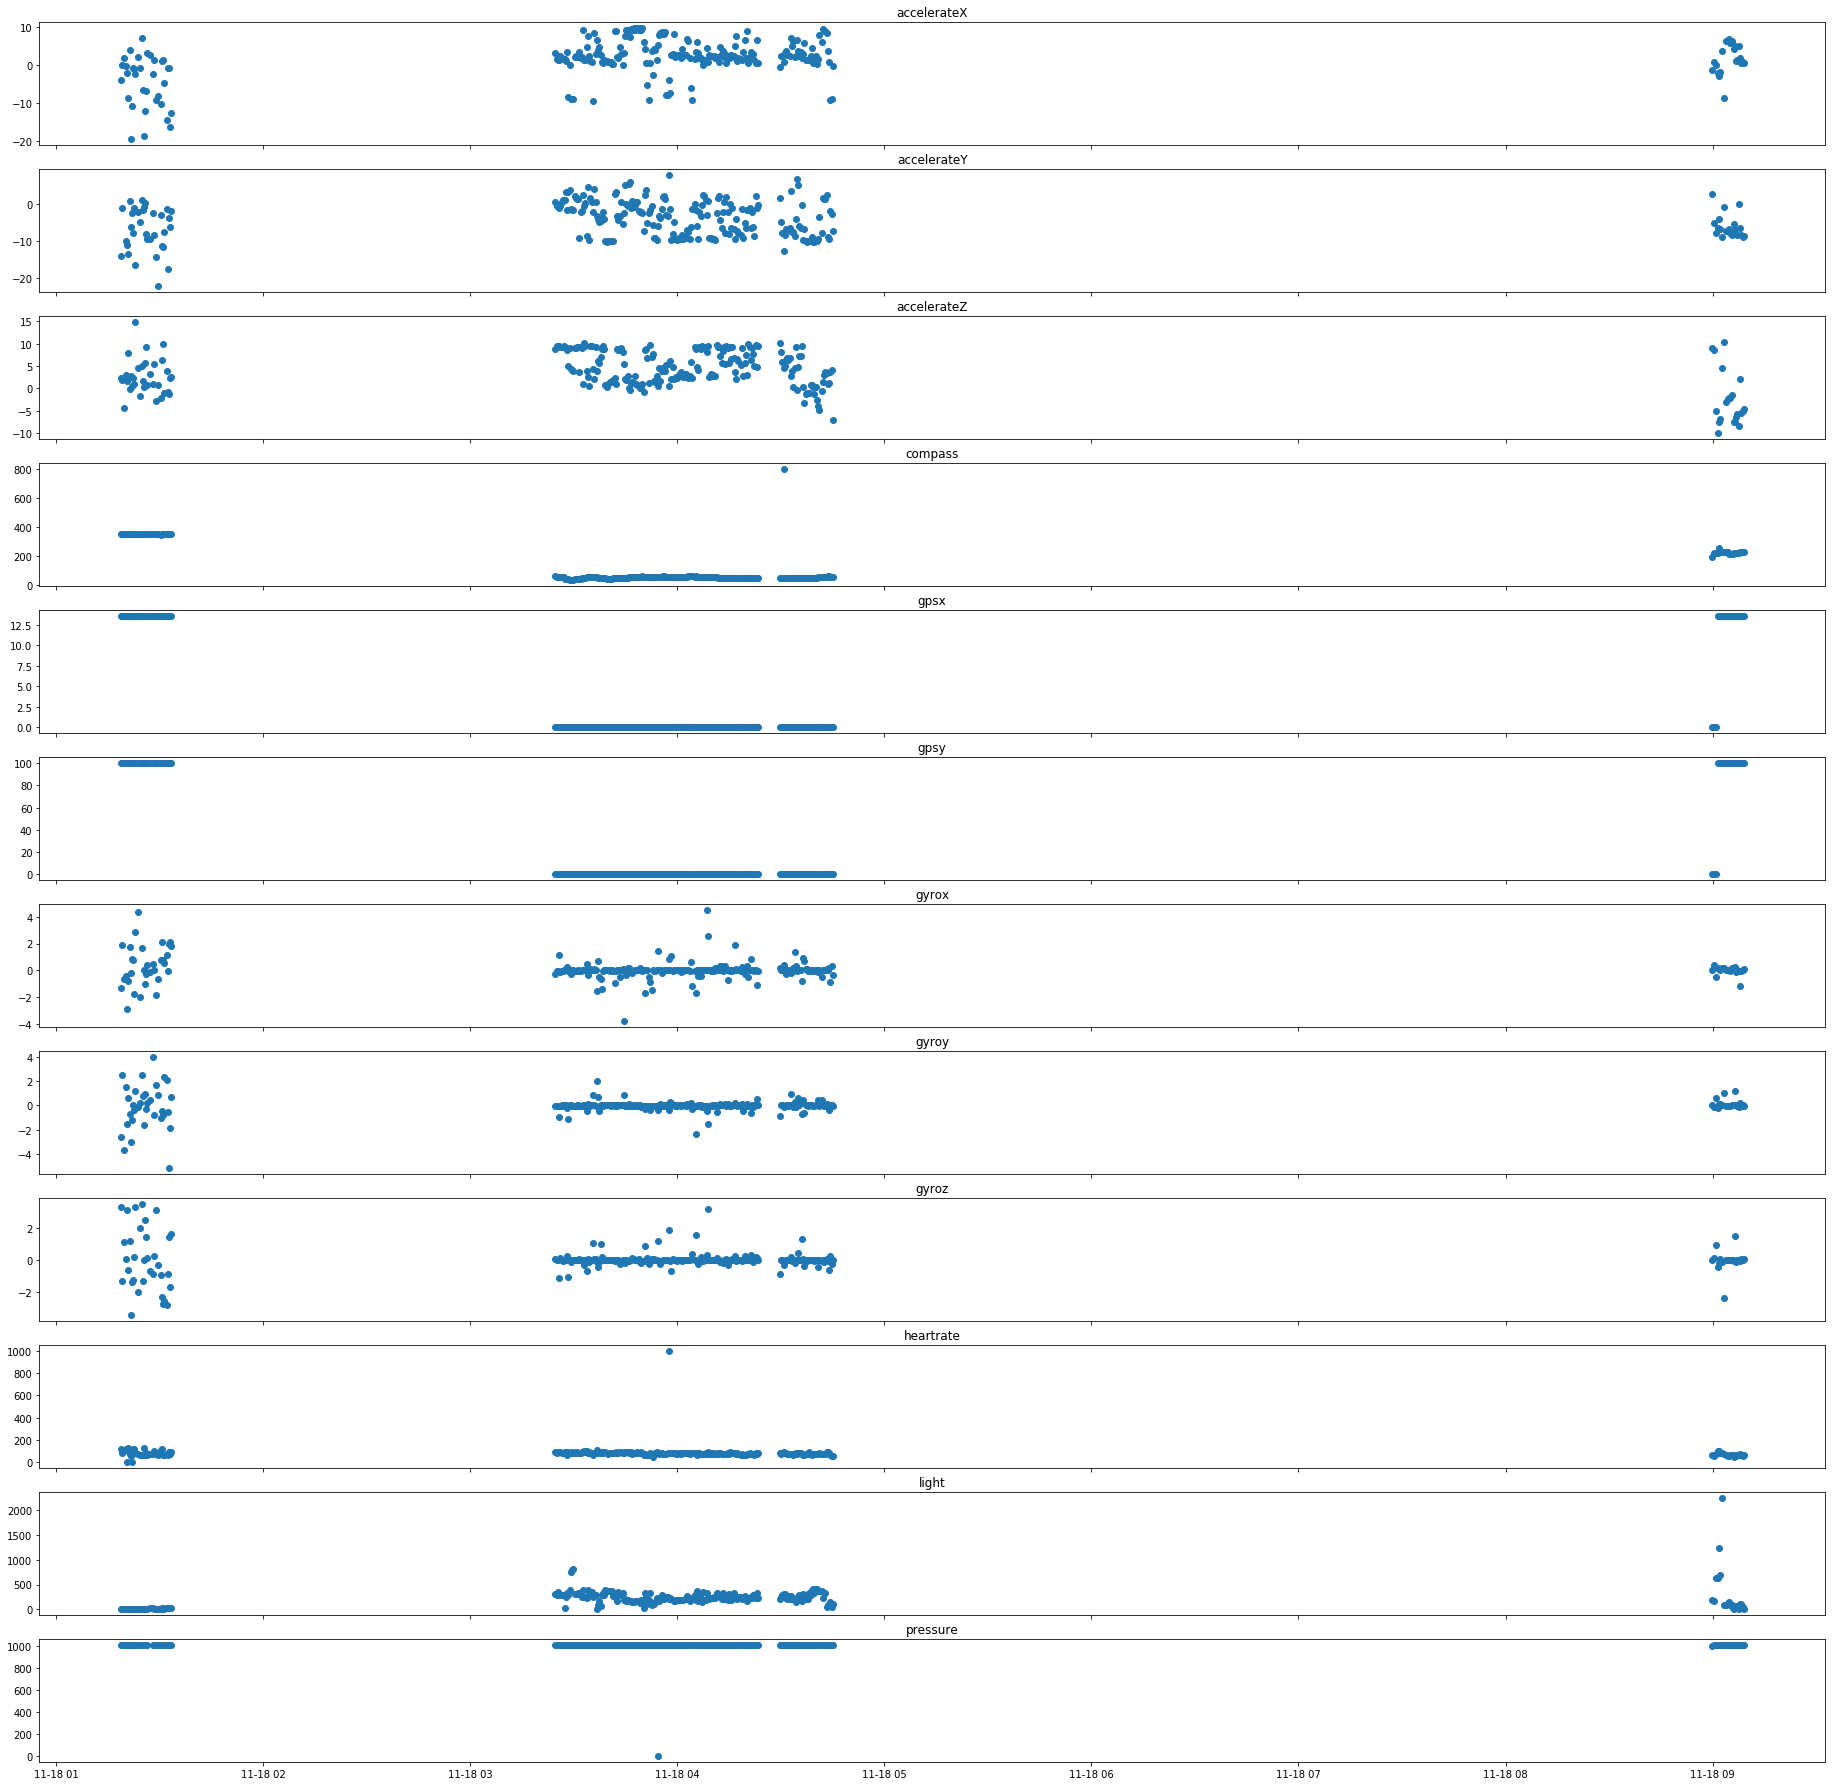

In [5]:
fig, ax = plt.subplots(len(rec.dtype), 1, figsize = (32, 32), sharex=True)
for i, col in enumerate(rec.dtype.names):
    ax[i].plot_date(rec_uni['uts'], rec[col])
    ax[i].set_title(col)

# Replace Zero to NaN

In [6]:
for col in ['heartrate', 'pressure', 'compass']:
    rec[col][rec[col] == 0] = np.nan

# Show NaN

In [7]:
# view = rec.view(np.float64).reshape(-1, 12)

# rec_uni[np.any(np.isnan(view), axis=1)]

# Fill NaN with Interpolation

In [8]:
before_interpola = rec['accelerateY'][:4].copy()

for col in ['accelerateX', 'accelerateY', 'accelerateZ', 'gyrox', 'gyroy', 'gyroz', 'heartrate', 'light', 'pressure']:
    indices = np.arange(rec[col].shape[0])
    not_nan = ~np.isnan(rec[col])
    rec[col] = np.interp(indices, indices[not_nan], rec[col][not_nan])

before_interpola, rec['accelerateY'][:4]

(array([-14.204506 ,  -1.1566253,         nan, -10.149148 ]),
 array([-14.204506  ,  -1.1566253 ,  -5.65288665, -10.149148  ]))

# Export acc

In [9]:
col_acc = ['accelerateX', 'accelerateY', 'accelerateZ']
acc = repack_fields(rec[col_acc]).view(np.float64).reshape(-1, 3)

np.save('data.npy', acc)

# Fill Outlier with SD

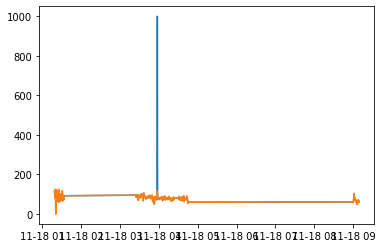

In [10]:
plt.plot(rec_uni['uts'], rec['heartrate'])

for col in ['heartrate', 'compass', 'light']:
    cond = abs(rec[col] - np.mean(rec[col])) > 2*np.std(rec[col])
    rec[col][cond] = 2*np.std(rec[col])

plt.plot(rec_uni['uts'], rec['heartrate'])

## Moving avg

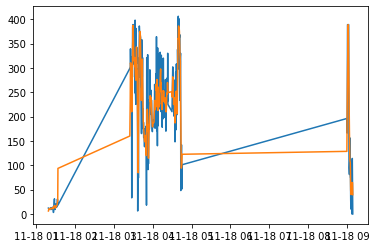

In [11]:
plt.plot(rec_uni['uts'], rec['light'])

for col in ['accelerateX', 'accelerateY', 'accelerateZ', 'gyrox', 'gyroy', 'gyroz', 'light']:
    rec[col] = np.convolve(rec[col], np.ones(8)/8, mode='same')
    
plt.plot(rec_uni['uts'], rec['light'])

# Standardized Norm

In [12]:
view = rec.view(np.float64).reshape(-1, 12)
std_norm = (view - np.mean(view)) / np.std(view)

rec_norm = rec.copy()
for i, col in enumerate(rec_norm.dtype.names):
    rec_norm[col] = std_norm[:,i]

# Visualization 

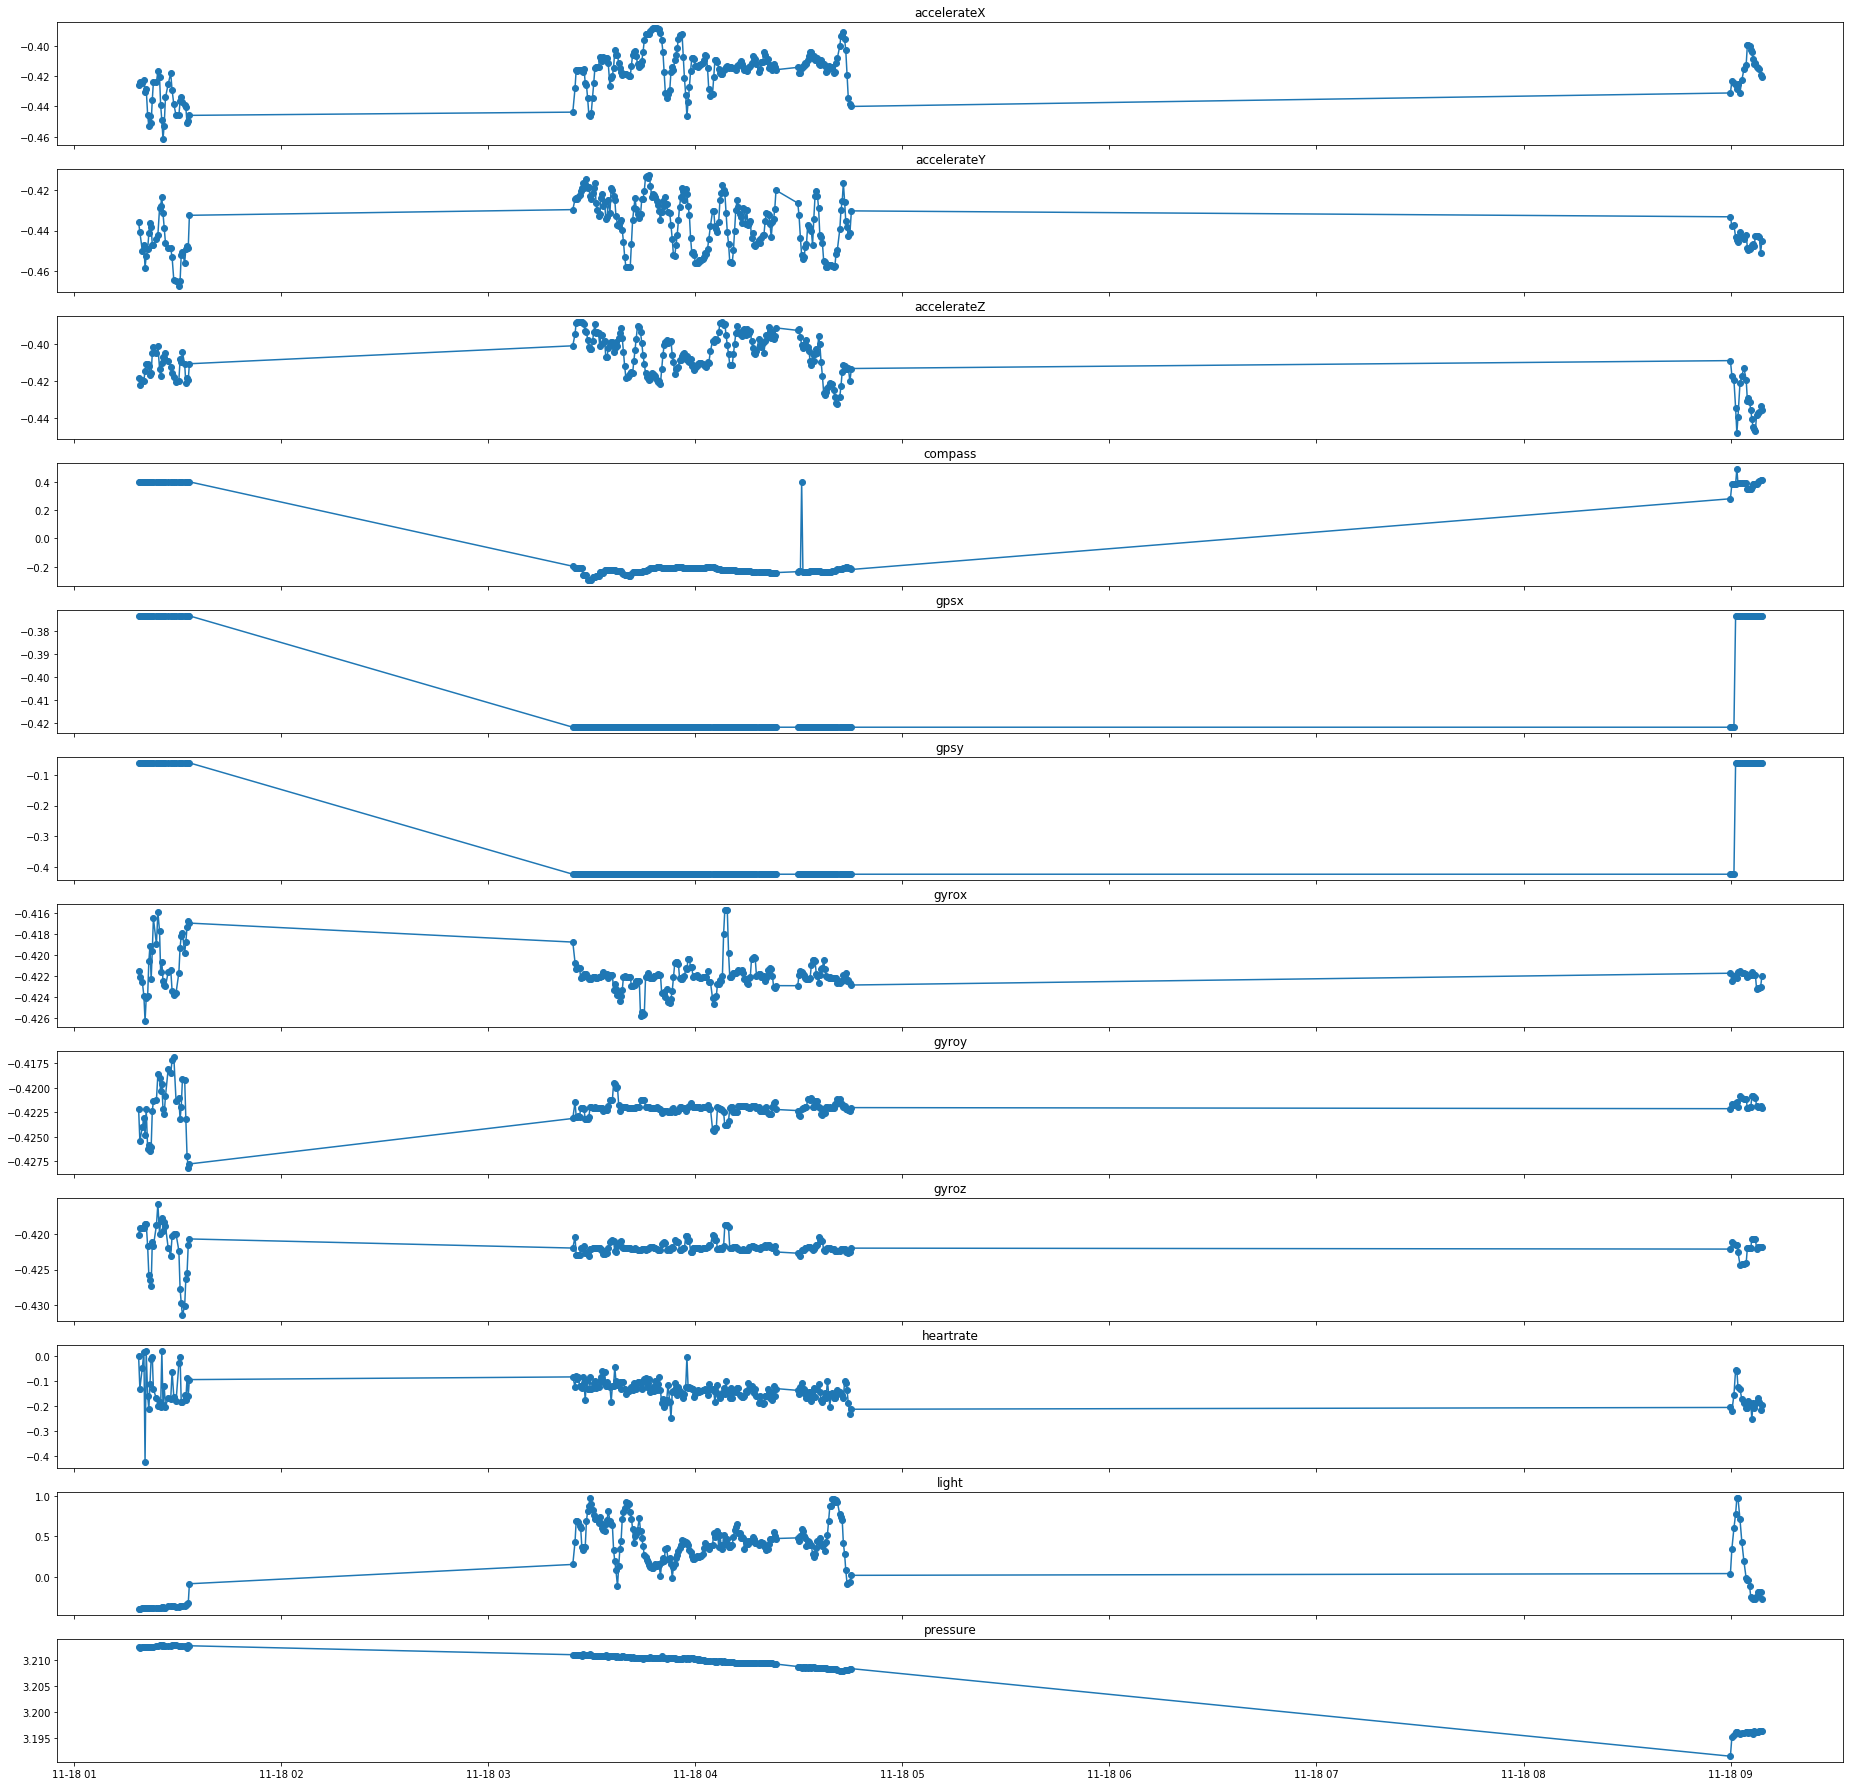

In [13]:
fig, ax = plt.subplots(len(rec.dtype), 1, figsize = (32, 32), sharex=True)
for i, col in enumerate(rec.dtype.names):
    ax[i].plot_date(rec_uni['uts'], rec_norm[col], linestyle='-')
    ax[i].set_title(col)

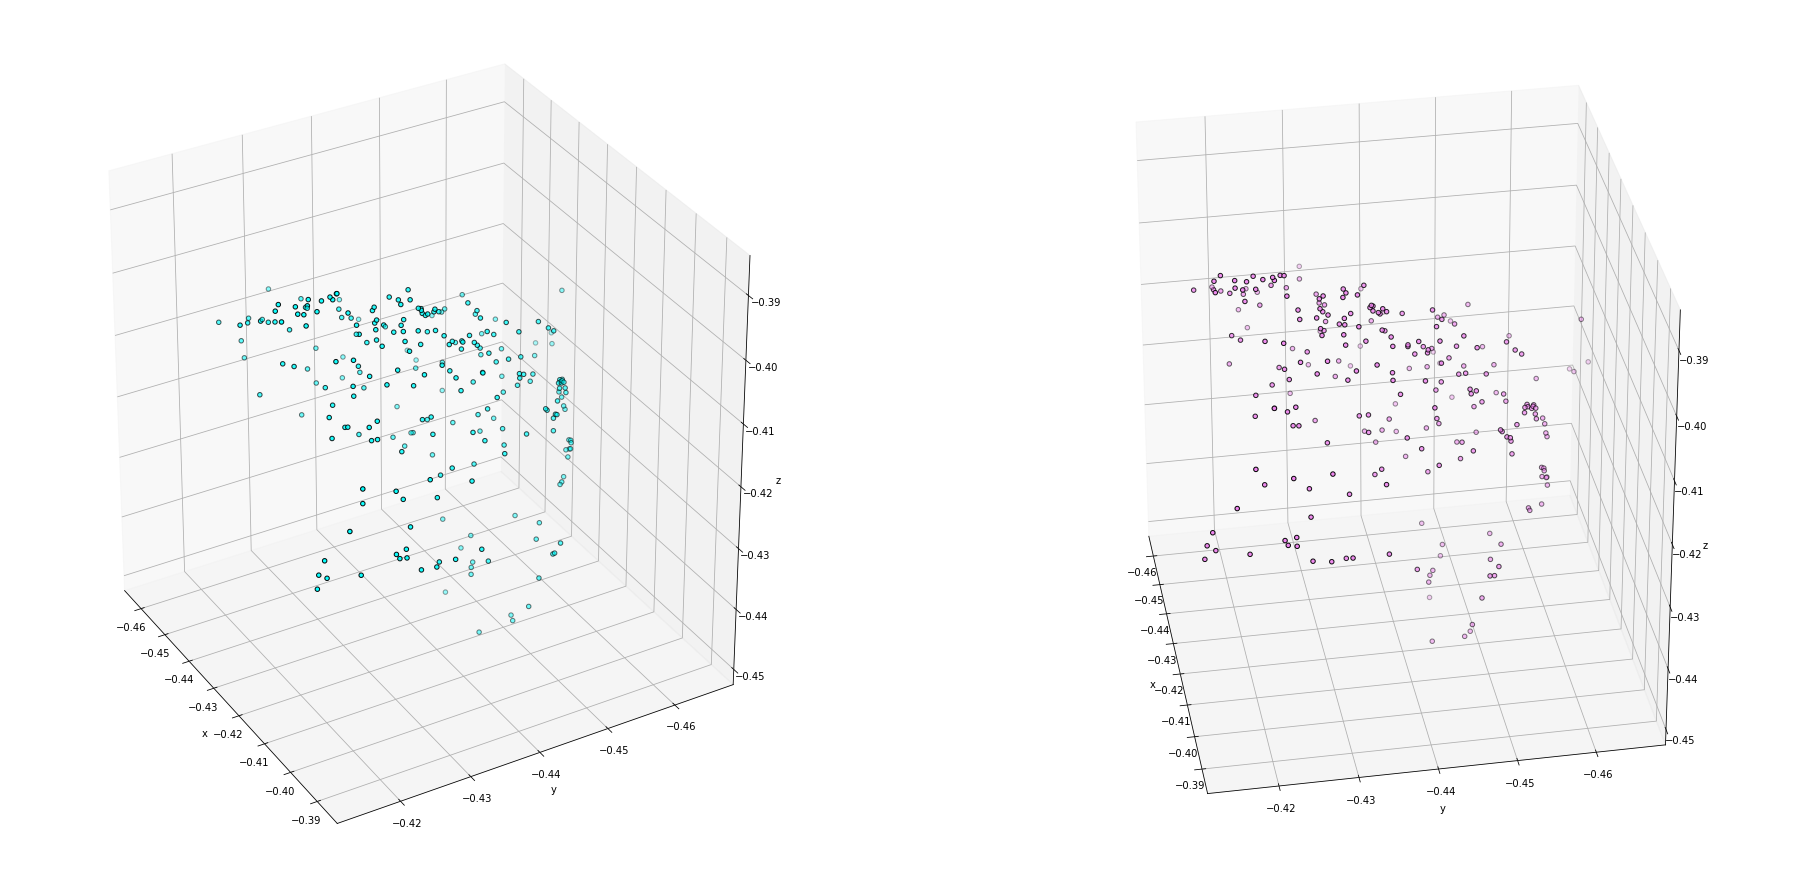

In [14]:
x, y, z = repack_fields(rec_norm[col_acc]).view(np.float64).reshape(-1, 3).T

figsize = (32, 16)
fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(x, y, z, c='cyan', s=20, edgecolor='k')
ax.set_ylim3d(np.max(y), np.min(y))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -30)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(x, y, z, c='violet', s=20, edgecolor='k')
ax.set_ylim3d(np.max(y), np.min(y))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -10)

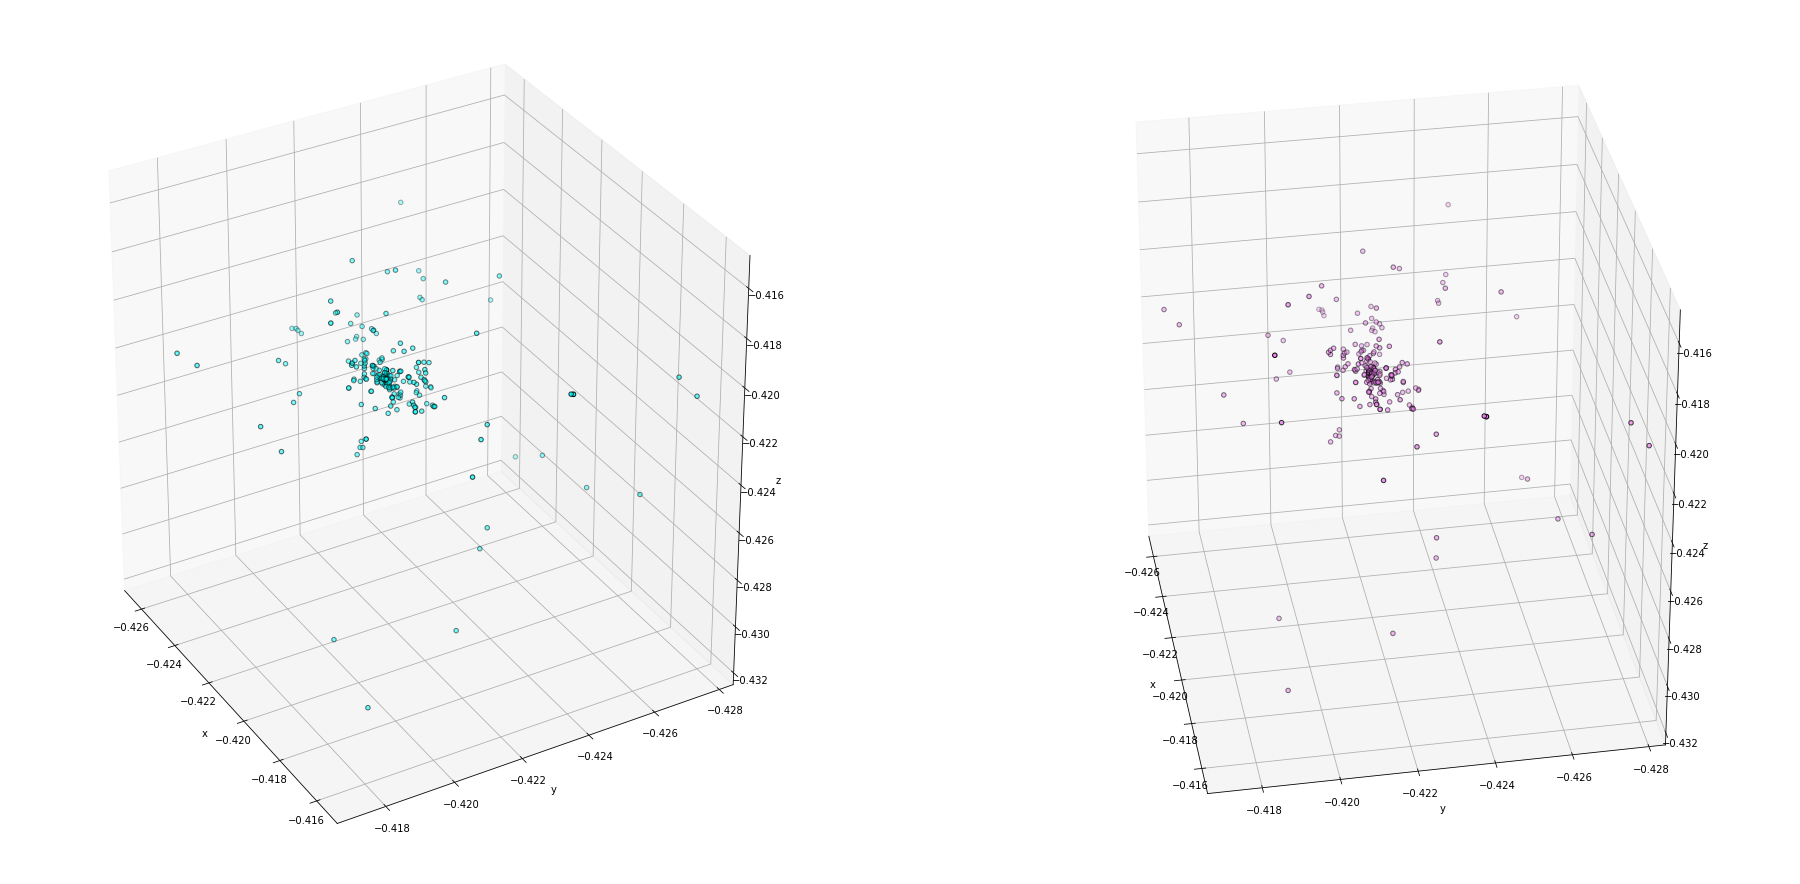

In [15]:
col_gyro = ['gyrox', 'gyroy', 'gyroz']
x, y, z = repack_fields(rec_norm[col_gyro]).view(np.float64).reshape(-1, 3).T

figsize = (32, 16)
fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(x, y, z, c='cyan', s=20, edgecolor='k')
ax.set_ylim3d(np.max(y), np.min(y))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -30)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(x, y, z, c='violet', s=20, edgecolor='k')
ax.set_ylim3d(np.max(y), np.min(y))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -10)

# Geolocation

In [16]:
arr_gps = repack_fields(rec[rec['gpsx'] != 0][['gpsx', 'gpsy']]).view(np.float64).reshape(-1, 2)
arr_gps = arr_gps[np.any(~np.isnan(arr_gps), axis=1)]

b_box = (arr_gps[:, 0].min(), arr_gps[:, 0].max(),      
         arr_gps[:, 1].min(), arr_gps[:, 1].max())

b_box

(13.54799667, 13.62157333, 100.276605, 100.3691717)

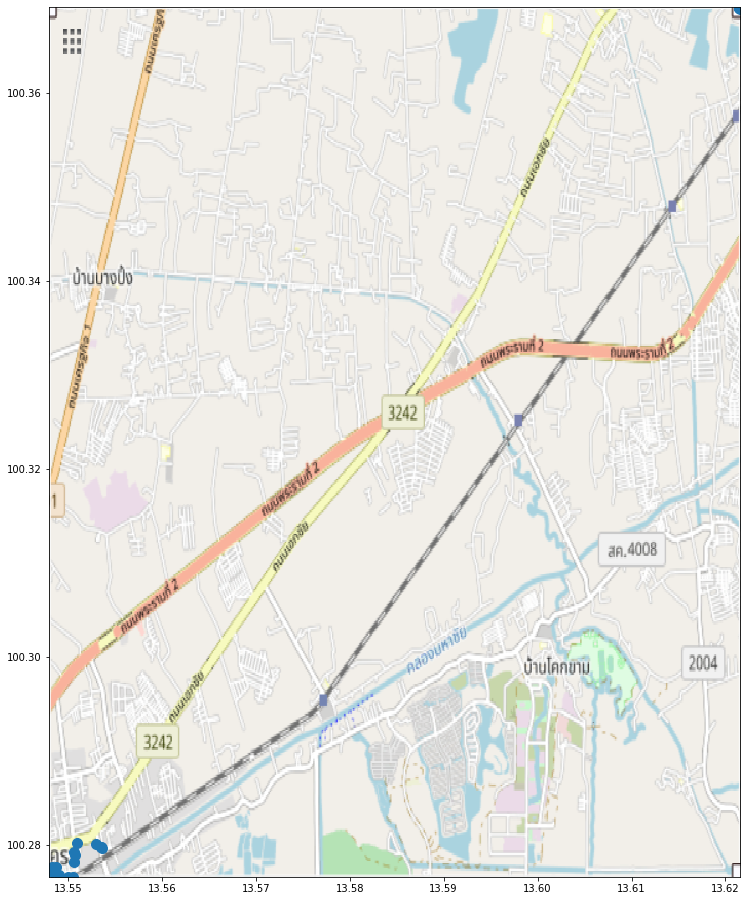

In [17]:
fig, ax = plt.subplots(figsize = (16, 16))
ax.scatter(arr_gps[:, 0], arr_gps[:, 1], s=100)
ax.set_xlim(b_box[0], b_box[1])
ax.set_ylim(b_box[2], b_box[3])

map_im = plt.imread('map.png')
ax.imshow(map_im, zorder=0, extent = b_box, aspect= 'equal')

# Data Formate

In [18]:
col_sel = ['accelerateX', 'accelerateY', 'accelerateZ', 'compass', 'heartrate']

arr_1 = rec.view(np.float64).reshape(-1, 12)[:, [0,1,2,3,9]]
arr_1.shape

(263, 5)

In [19]:
# np.lib.stride_tricks.as_strided(a, shape=(4,6), strides=(8,4))
time_window = 20
time_step = 5
n_feature = arr_1.shape[1]
n_len = arr_1.shape[0]

segments = [arr_1[i: i+time_window] for i in range(0, n_len -time_window, time_step)]
arr_2 = np.array(segments, dtype=np.float64).reshape(-1, time_window, n_feature)

arr_2.shape

(49, 20, 5)

In [20]:
arr_2 = arr_2.reshape(-1, n_feature)
arr_2.shape

(980, 5)

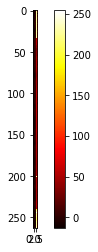

In [21]:
plt.imshow(arr_1, cmap='hot', interpolation='nearest')
plt.colorbar()